In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

info = pd.read_excel("../../1_analysis_of_rna_seq/RNAseq.xls")
info = info[~info["Replicate"].isna()]
print(len(info))

66


# Correlation of FPKM between samples

In [2]:
tissues = list(sorted(set(info["Tissue"])))
print(tissues)
mapper = {t[:2]: t for t in tissues}
print(mapper)
letter_to_tissue = {t[:2]: t for t in tissues}

['Brain', 'Eye', 'Gill', 'Gonad', 'Heart', 'Intestine', 'Kidney', 'Liver', 'Muscle', 'Pituitary', 'Spleen', 'Stomach']
{'Br': 'Brain', 'Ey': 'Eye', 'Gi': 'Gill', 'Go': 'Gonad', 'He': 'Heart', 'In': 'Intestine', 'Ki': 'Kidney', 'Li': 'Liver', 'Mu': 'Muscle', 'Pi': 'Pituitary', 'Sp': 'Spleen', 'St': 'Stomach'}


In [3]:
dat = pd.read_csv("../../3_integrate_isoforms/results/expression/stringtie/asm.gene_abund.tsv", sep="\t", index_col=0)
samples = dat.columns
groups = list(sorted(set([s[:-2] for s in samples])))
print(groups)

['Ad_Br_Fe', 'Ad_Br_Ma', 'Ad_Ey_Fe', 'Ad_Ey_Ma', 'Ad_Gi_Fe', 'Ad_Gi_Ma', 'Ad_Go_Fe', 'Ad_Go_Ma', 'Ad_He_Fe', 'Ad_He_Ma', 'Ad_In_Fe', 'Ad_In_Ma', 'Ad_Ki_Fe', 'Ad_Ki_Ma', 'Ad_Li_Fe', 'Ad_Li_Ma', 'Ad_Mu_Fe', 'Ad_Mu_Ma', 'Ad_Pi_Fe', 'Ad_Pi_Ma', 'Ad_Sp_Fe', 'Ad_Sp_Ma', 'Ad_St_Fe', 'Ad_St_Ma', 'Ju_Br_Mi', 'Ju_Ey_Mi', 'Ju_Gi_Mi', 'Ju_Go_Mi', 'Ju_He_Mi', 'Ju_In_Mi', 'Ju_Ki_Mi', 'Ju_Li_Mi', 'Ju_Mu_Mi']


Ad_Br_Fe Adult brain (female)
Ad_Br_Ma Adult brain (male)
Ad_Ey_Fe Adult eye (female)
Ad_Ey_Ma Adult eye (male)
Ad_Gi_Fe Adult gill (female)
Ad_Gi_Ma Adult gill (male)
Ad_Go_Fe Adult gonad (female)
Ad_Go_Ma Adult gonad (male)
Ad_He_Fe Adult heart (female)
Ad_He_Ma Adult heart (male)
Ad_In_Fe Adult intestine (female)
Ad_In_Ma Adult intestine (male)
Ad_Ki_Fe Adult kidney (female)
Ad_Ki_Ma Adult kidney (male)
Ad_Li_Fe Adult liver (female)
Ad_Li_Ma Adult liver (male)
Ad_Mu_Fe Adult muscle (female)
Ad_Mu_Ma Adult muscle (male)
Ad_Pi_Fe Adult pituitary (female)
Ad_Pi_Ma Adult pituitary (male)
Ad_Sp_Fe Adult spleen (female)
Ad_Sp_Ma Adult spleen (male)
Ad_St_Fe Adult stomach (female)
Ad_St_Ma Adult stomach (male)
Ju_Br_Mi Juvenile brain
Ju_Ey_Mi Juvenile eye
Ju_Gi_Mi Juvenile gill
Ju_Go_Mi Juvenile gonad
Ju_He_Mi Juvenile heart
Ju_In_Mi Juvenile intestine
Ju_Ki_Mi Juvenile kidney
Ju_Li_Mi Juvenile liver
Ju_Mu_Mi Juvenile muscle


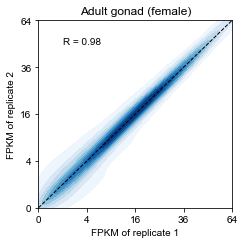

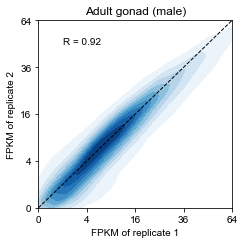

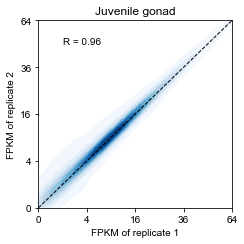

In [83]:
rs = [] # list of r

for group in groups:

    if group.startswith("Ju"):
        title = "Juvenile %s" % mapper[group.split("_")[1]].lower()
    else:
        title = "Adult %s (%s)" % (mapper[group.split("_")[1]].lower(), "male" if group.endswith("Ma") else "female")
    print(group, title)
    
    sample1, sample2 = list(filter(lambda s: s.startswith(group), samples))
    xs = dat[sample1]
    ys = dat[sample2]
    flags = (xs >= 1) & (ys >= 1)
    xs, ys = xs[flags], ys[flags]
    xs, ys = np.log2(xs), np.log2(ys)
    r = np.corrcoef(xs, ys)[0][1]
    rs.append(r)
    
    if "_Go_" in group:
        plt.figure(figsize=(3.5, 3.5))
        plt.title(title)
        sns.kdeplot(x=xs, y=ys, fill=True, cmap='Blues', cbar=False, alpha=1, zorder=2)
        lim = 8
        plt.plot([0, lim], [0, lim], lw=1, ls="--", color="black")
        plt.xlim(0, lim)
        plt.ylim(0, lim)
        vs = np.arange(0, 8 + 1, 2)
        ticks = list(map(str, vs ** 2))
        plt.xticks(vs, ticks)
        plt.yticks(vs, ticks)
        plt.text(1, 7, "R = %.2f" % r)
        plt.xlabel("FPKM of replicate 1")
        plt.ylabel("FPKM of replicate 2")
        plt.tight_layout()
        plt.savefig("figures/correlation_of_replicates.scatter.%s.pdf" % group, dpi=300)
        # plt.close()
        # break

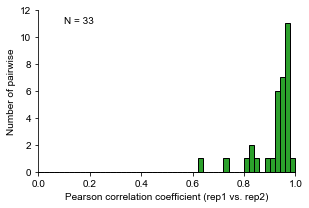

In [92]:
vs = np.array(rs)
# vs = vs ** 2
plt.figure(figsize=(4.4, 3))
plt.hist(vs, bins=50, range=(0, 1), edgecolor="black", color="C2", clip_on=False)
plt.xlim(0, 1)
plt.ylim(0, 12)
plt.text(0.1, 11, "N = %d" % len(vs))
plt.xlabel("Pearson correlation coefficient (rep1 vs. rep2)")
plt.ylabel("Number of pairwise")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/density_of_pearson_corrcoef.pdf", dpi=300)

In [30]:
array = []
for group in groups:
    sample1, sample2 = list(filter(lambda s: s.startswith(group), dat.columns))
    s = dat[[sample1, sample2]].mean(axis=1)
    s.name = group
    array.append(s)
m = pd.concat(array, axis=1)
m.to_csv("results/fpkms.all_groups.tsv", sep="\t")

# FPKM distribution

## Cumulative curve

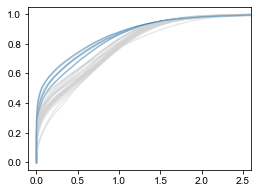

In [171]:

m = pd.read_csv("results/fpkms.all_groups.tsv", sep="\t", index_col=0)
m = m[m.max(axis=1) >= 1]

plt.figure(figsize=(4, 3))
for c in m.columns:
    xs = np.array(list(sorted(m[c])))
    xs = np.log10(xs + 1)
    ys = np.arange(len(xs)) / len(xs)
    color = "lightgrey"
    if "Mu" in c:
        color = "C0"
    plt.plot(xs, ys, color=color, alpha=0.5)
plt.xlim(-0.1, 2.6)
plt.show()

## Boxplot

In [105]:
m = pd.read_csv("results/fpkms.all_groups.tsv", sep="\t", index_col=0)
m = m[m.max(axis=1) >= 1]
m.head()

,Ad_Br_Fe,Ad_Br_Ma,Ad_Ey_Fe,Ad_Ey_Ma,Ad_Gi_Fe,Ad_Gi_Ma,Ad_Go_Fe,Ad_Go_Ma,Ad_He_Fe,Ad_He_Ma,...,Ad_St_Ma,Ju_Br_Mi,Ju_Ey_Mi,Ju_Gi_Mi,Ju_Go_Mi,Ju_He_Mi,Ju_In_Mi,Ju_Ki_Mi,Ju_Li_Mi,Ju_Mu_Mi
GeneID,,,,,,,,,,,,,,,,,,,,,
abl2,2.256521,1.925558,2.781183,2.395351,9.875788,2.818788,8.092579,3.980338,1.694431,1.838901,...,2.895857,1.886183,7.197182,10.837047,2.833092,1.871590,1.239274,1.970756,0.399389,0.500562
soat1,2.392571,3.454524,0.803461,1.211381,0.363799,0.513220,6.646222,1.838533,0.171823,0.210814,...,68.334612,5.153960,1.677690,0.118124,1.366823,0.016943,0.360609,0.983695,0.000000,0.016411
dnttip2,4.742001,3.903420,4.962518,2.872238,6.399140,5.069499,14.415564,6.022341,5.676184,7.550802,...,3.111963,2.472780,5.686459,5.846749,6.401608,3.624636,2.175484,8.264904,7.519040,3.998696
spata6_agbl4,3.254716,3.734259,3.006632,2.771479,0.574307,0.368005,0.653523,24.306386,0.540164,0.825272,...,0.379357,4.274557,0.713651,0.347984,2.189504,0.157406,0.288481,1.327739,0.714326,0.060245
spata6,0.241802,0.302351,0.303582,0.251037,0.379777,0.570247,0.089388,2.229303,0.684611,0.809908,...,0.550692,0.401132,0.293119,1.117530,0.664033,0.399145,0.276341,0.271549,0.068205,0.023550


In [139]:
rows = []
for c in m.columns:
    v1, v2, v3 = c.split("_")
    
    s = m[c]
    tissue = letter_to_tissue[v2]
    stage = "%s_%s" % (v1, v3)
    if stage == "Ju_Mi":
        stage = "Juvenile"
    elif stage == "Ad_Ma":
        stage = "Adult male"
    else:
        stage = "Adult female"
    for gene, fpkm in zip(s.index, s):
        rows.append([tissue, stage, gene, np.log10(1 + fpkm)])
    # break
d = pd.DataFrame(rows, columns=["Tissue", "Stage", "Gene", "FPKM"])
d.head()

,Tissue,Stage,Gene,FPKM
0,Brain,Adult female,abl2,0.512754
1,Brain,Adult female,soat1,0.530529
2,Brain,Adult female,dnttip2,0.759063
3,Brain,Adult female,spata6_agbl4,0.628871
4,Brain,Adult female,spata6,0.094052


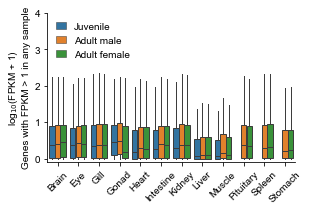

In [176]:
plt.figure(figsize=(4.4, 3))
ret = sns.boxplot(data=d, x="Tissue", y="FPKM", hue="Stage", fliersize=0, linewidth=1, showcaps=False,
                  hue_order=["Juvenile", "Adult male", "Adult female"])
plt.ylim(-0.1, 4)
plt.xticks(rotation=45)
plt.xlabel(None)
plt.ylabel("log$_{10}$(FPKM + 1)\nGenes with FPKM > 1 in any sample")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(loc="upper left", bbox_to_anchor=(0, 1), ncol=1, frameon=False, handlelength=1)
plt.tight_layout()
plt.savefig("figures/fpkm_distribution.pdf", dpi=300)

# Correlation between groups (heatmap)

In [4]:
m = pd.read_csv("results/fpkms.all_groups.tsv", sep="\t", index_col=0)
m = m[m.max(axis=1) >= 1]
m = m.corr()

if True:
    m.columns = ["%s_%s_%s" % (s[0:2], s[6:8], s[3:5]) for s in m.columns]
    m.index = ["%s_%s_%s" % (s[0:2], s[6:8], s[3:5]) for s in m.index]
m.head()

,Ad_Fe_Br,Ad_Ma_Br,Ad_Fe_Ey,Ad_Ma_Ey,Ad_Fe_Gi,Ad_Ma_Gi,Ad_Fe_Go,Ad_Ma_Go,Ad_Fe_He,Ad_Ma_He,...,Ad_Ma_St,Ju_Mi_Br,Ju_Mi_Ey,Ju_Mi_Gi,Ju_Mi_Go,Ju_Mi_He,Ju_Mi_In,Ju_Mi_Ki,Ju_Mi_Li,Ju_Mi_Mu
Ad_Fe_Br,1.000000,0.939606,0.546983,0.597921,0.638700,0.630403,0.376928,0.548467,0.533827,0.554505,...,0.309408,0.907161,0.316181,0.623877,0.603087,0.449972,0.366991,0.539397,0.335036,0.184796
Ad_Ma_Br,0.939606,1.000000,0.541226,0.587546,0.653677,0.644933,0.390135,0.550769,0.548303,0.570611,...,0.319226,0.942072,0.322426,0.641560,0.619744,0.467278,0.381100,0.555895,0.367525,0.190397
Ad_Fe_Ey,0.546983,0.541226,1.000000,0.956591,0.578652,0.578841,0.323377,0.471506,0.488939,0.515048,...,0.282961,0.525958,0.669107,0.564270,0.553334,0.414049,0.333089,0.492747,0.303542,0.183227
Ad_Ma_Ey,0.597921,0.587546,0.956591,1.000000,0.567291,0.566276,0.331994,0.476025,0.482769,0.507591,...,0.288459,0.581237,0.547952,0.553985,0.547773,0.410556,0.333559,0.489319,0.302230,0.166346
Ad_Fe_Gi,0.638700,0.653677,0.578652,0.567291,1.000000,0.988364,0.484235,0.650162,0.669380,0.712539,...,0.413865,0.635445,0.402270,0.951270,0.814513,0.550896,0.483950,0.697649,0.442010,0.233760


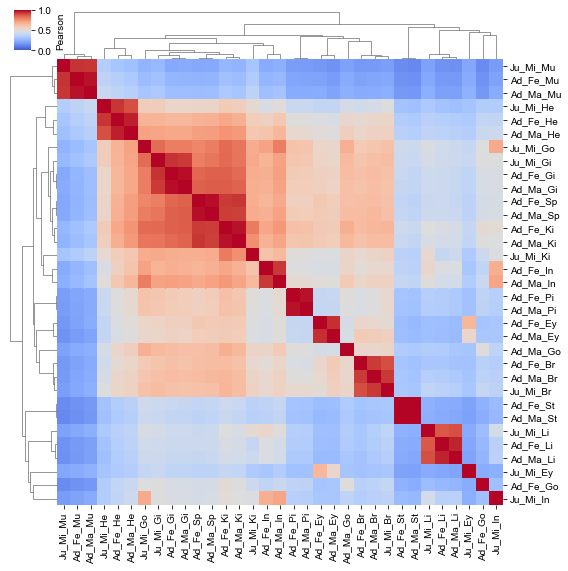

In [10]:
ret = sns.clustermap(m, vmin=0, vmax=1, cmap="coolwarm", dendrogram_ratio=0.1, 
                     figsize=(8, 8), 
                     cbar_pos=(0.03, 0.91, 0.03, 0.07), cbar_kws=dict(label="Pearson"))
ret.savefig("figures/corrcoef_groups_heatmap.pdf", dpi=300)

In [6]:
m.to_csv("results/corrcoef_groups.tsv", sep="\t")